The first stage of image processing here is to resize the images. The input to this net is 227x227. Resizing the images could be slow - there are faster ways but not without playing around with the machinery...

In [20]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
img = Image.open('../100001.jpg')
print img.size < dWidth
if any(img.size > dWidth):
    print 'yay'
#img = plt.imread('../100000.jpg')
plt.imshow(img)
plt.show()

False


TypeError: 'bool' object is not iterable

In [17]:
dWidth = 227 # The desired width
dHeight = 227 # The desired height

Could simply resize the images and be done with it. However a better way would be to crop the images, to maintain the aspect ratio.

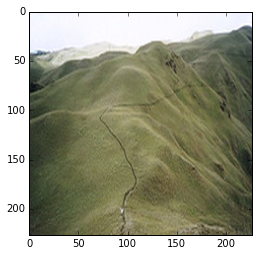

In [23]:
imgNoAspect = img.resize((dWidth, dHeight), PIL.Image.ANTIALIAS)
plt.imshow(imgNoAspect)
plt.show()

Use the algorithm from http://united-coders.com/christian-harms/image-resizing-tips-every-coder-should-know/ to efficiently do this

In [58]:
def resize(img, box, fit, out):
    '''Downsample the image.
    @param img: Image -  an Image-object
    @param box: tuple(x, y) - the bounding box of the result image
    @param fit: boolean - crop the image to fill the box
    @param out: file-like-object - save the image into the output stream
    '''
    #preresize image with factor 2, 4, 8 and fast algorithm
    factor = 1
    while img.size[0]/factor > 2*box[0] and img.size[1]*2/factor > 2*box[1]:
        factor *=2
    if factor > 1:
        img.thumbnail((img.size[0]/factor, img.size[1]/factor), Image.NEAREST)

    #calculate the cropping box and get the cropped part
    if fit:
        x1 = y1 = 0
        x2, y2 = img.size
        wRatio = 1.0 * x2/box[0]
        hRatio = 1.0 * y2/box[1]
        if hRatio > wRatio:
            y1 = int(y2/2-box[1]*wRatio/2)
            y2 = int(y2/2+box[1]*wRatio/2)
        else:
            x1 = int(x2/2-box[0]*hRatio/2)
            x2 = int(x2/2+box[0]*hRatio/2)
        img = img.crop((x1,y1,x2,y2))

    #Resize the image with best quality algorithm ANTI-ALIAS
    img.thumbnail(box, Image.ANTIALIAS)

    #save it into a file-like object
    #img.save(out, "JPEG", quality=75)
    return img
#resize

In [105]:
def resize2(img, box, fit, out):
    '''Downsample the image.
    A second version of this was made, which uses resize rather than the 
    thumbnail function, since this this won't upsize images.
    '''
    #preresize image with factor 2, 4, 8 and fast algorithm
    factor = 1
    while img.size[0]/factor > 2*box[0] and img.size[1]*2/factor > 2*box[1]:
        factor *=2
    if factor > 1:
        img.thumbnail((img.size[0]/factor, img.size[1]/factor), Image.NEAREST)

    #calculate the cropping box and get the cropped part
    if fit:
        x1 = y1 = 0
        x2, y2 = img.size
        wRatio = 1.0 * x2/box[0]
        hRatio = 1.0 * y2/box[1]
        if hRatio > wRatio:
            y1 = int(y2/2-box[1]*wRatio/2)
            y2 = int(y2/2+box[1]*wRatio/2)
        else:
            x1 = int(x2/2-box[0]*hRatio/2)
            x2 = int(x2/2+box[0]*hRatio/2)
        img = img.crop((x1,y1,x2,y2))

    #Resize the image with best quality algorithm ANTI-ALIAS. If the image is 
    # larger then use the thumbnail as per
    if all([x > box[0] for x in img.size]):
        img.thumbnail(box, Image.ANTIALIAS)
        print 'I used thumbnail'
    else:
        img = img.resize(box, Image.ANTIALIAS)

    #save it into a file-like object
    img.save(out, "JPEG", quality=75)
    return img
#resize

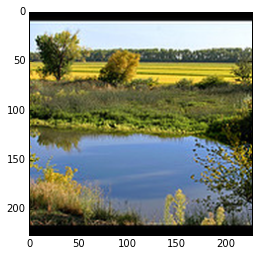

In [85]:
newImg = resize2(img, (dWidth, dHeight), True, 'a')
plt.imshow(newImg)
plt.show()

Compare the speed of each one using a timing wrapper. First define the wrapper function and then record the time to perform each operation

In [41]:
import timeit

In [45]:
tic=timeit.default_timer()
newImg = resize(img, (dWidth, dHeight), True, 'a')
toc = timeit.default_timer()
print "The time for the simple resize in ms is {}".format((toc-tic)*1000)

The time for the simple resize in ms is 0.224113464355


In [95]:
tic=timeit.default_timer()
imgNoAspect = img.resize((dWidth, dHeight), PIL.Image.ANTIALIAS)
toc = timeit.default_timer()
print "The time for the built in resize in ms is {}".format((toc-tic)*1000)

The time for the built in resize in ms is 5.88202476501


In [106]:
tic=timeit.default_timer()
newImg2 = resize2(img, (dWidth, dHeight), True, 'pointless string')
toc = timeit.default_timer()
print "The time for new resizer in ms is {}".format((toc-tic)*1000)

The time for new resizer in ms is 8.89706611633


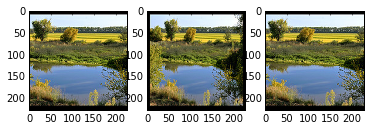

In [96]:
plt.subplot(131)
plt.imshow(newImg)
plt.subplot(132)
plt.imshow(imgNoAspect)
plt.subplot(133)
plt.imshow(newImg2)
plt.show()

Just to check that the larger image will trigger the fast resizing method. 

In [102]:
bigImage = img.resize((500,500),PIL.Image.ANTIALIAS)
tic=timeit.default_timer()
smallAgain = resize(bigImage, (dWidth, dHeight), True, 'pointless string')
toc = timeit.default_timer()
print "The time for new resizer in ms is {}".format((toc-tic)*1000)

(227, 227)
The time for new resizer in ms is 8.02516937256


In [107]:
from os import listdir
listdir('.')


['Create data subsets.ipynb',
 '.ipynb_checkpoints',
 'files.txt',
 'labels.txt',
 'deploy_binary.prototxt~',
 'singlelabels.txt',
 'singlelabels_test.txt',
 'singlelabels_train.txt',
 'deploy.prototxt',
 'train_binary.prototxt~',
 'singlelabels_val.txt',
 'pointless string',
 'deploy_binary.prototxt',
 'Image Preprocessing.ipynb',
 'train_binary.prototxt']

Now we must deal with the mean of the image. Currently the mean is 256*256 (if we use the one from the original HybridCNN). For simplicity this is just resized

In [1]:
caffe_root = '/home/alex/Caffe/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
from caffe.proto import caffe_pb2
blob = caffe_pb2.BlobProto()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
sys.path.insert(0, '/home/alex/Documents/Caffe_First_Attempt/tools')
from my_resize import resize
from PIL import Image

In [2]:
data = open(caffe_root + 'models/hybridCNN/hybridCNN_mean.binaryproto').read()
blob.ParseFromString(data)
arr = np.array(caffe.io.blobproto_to_array(blob))

(3, 256, 256)


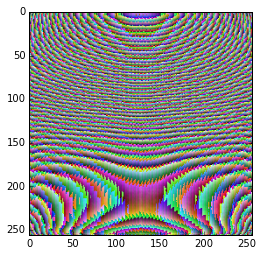

In [3]:
im = arr.squeeze()
print im.shape
plt.imshow(im.transpose(1,2,0))

Use the ready built resize function. Need to convert to use the from array method. 

In [21]:
img = resize(Image.fromarray(np.uint8(im.transpose(1,2,0))), (227,227),False,'')

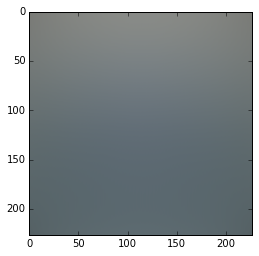

In [8]:
plt.imshow(img)

Without worrying too much about what sort of things have gone on to make this image now look so smooth lets convert this back to binary proto.

In [22]:
img = np.asarray(img)
img = np.expand_dims(img.transpose(2,0,1), 0)
blob = caffe.io.array_to_blobproto(img)
bpfile = open('resized_mean.binaryproto','w')
bpfile.write(blob